## Imports

In [71]:
import tensorflow as tf
from tfx import v1 as tfx

# TFX libraries
import tensorflow_data_validation as tfdv
import tensorflow_transform as tft
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext

# For performing feature selection
from sklearn.feature_selection import SelectKBest, f_classif

# For feature visualization
import matplotlib.pyplot as plt 
import seaborn as sns

# Utilities
from tensorflow.python.lib.io import file_io
from tensorflow_metadata.proto.v0 import schema_pb2
from google.protobuf.json_format import MessageToDict
from  tfx.proto import example_gen_pb2
from tfx.types import standard_artifacts
from tensorflow_transform.tf_metadata import dataset_metadata, schema_utils
import tensorflow_transform.beam as tft_beam
import os
import pprint
import tempfile
import pandas as pd

# To ignore warnings from TF
tf.get_logger().setLevel('ERROR')

# For formatting print statements
pp = pprint.PrettyPrinter()

# Display versions of TF and TFX related packages
print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))
print('TensorFlow Data Validation version: {}'.format(tfdv.__version__))
print('TensorFlow Transform version: {}'.format(tft.__version__))

TensorFlow version: 2.11.0
TFX version: 1.12.0
TensorFlow Data Validation version: 1.12.0
TensorFlow Transform version: 1.12.0


## Setup variables

In [72]:
# Declare paths to the data
DATA_DIR = '../data'
!ls {DATA_DIR}

TRAINING_DIR = f'{DATA_DIR}/training'
TRAINING_DATA = f'{DATA_DIR}/train.csv'
TEST_DATA = f'{DATA_DIR}/test.csv'
CENSUS_DATA = f'{DATA_DIR}/census_starter.csv'

# Create the directory
!mkdir -p {TRAINING_DIR}

census_starter.csv  sample_submission.csv  train.csv
revealed_test.csv   test.csv		   training


## Feature selection

In [86]:
test_df = pd.read_csv(TEST_DATA)
census_df = pd.read_csv(CENSUS_DATA)

# Preview the dataset
test_df.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


In [87]:
census_df.head()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


In [88]:
def pivot_census(category):
    """This function prepares and melts the census dataframe"""
    
    df_cols = [col for col in census_df.columns if category in col]  # select relevant columns
    df = census_df[df_cols+['cfips']] # subset the dataframe
    # renaming columns
    df_cols = [col[-4:] for col in df.drop('cfips', axis=1).columns]
    df.columns = df_cols+['cfips']
    # melting a dataframe
    df = pd.melt(df, id_vars='cfips', value_vars=['2017','2018','2019','2020','2021'],
                    var_name='year', value_name=category).sort_values('cfips').reset_index(drop=True)
    return df

pct_dd_df = pivot_census('pct_bb')
pct_dd_df.head()

,cfips,year,pct_bb
0,1001,2017,76.6
1,1001,2019,80.6
2,1001,2020,82.7
3,1001,2021,85.5
4,1001,2018,78.9


In [89]:
pct_college_df = pivot_census('pct_college')
pct_foreign_born_df = pivot_census('pct_foreign_born')
pct_it_workers_df = pivot_census('pct_it_workers')
median_hh_inc_df = pivot_census('median_hh_inc')

tmp = pd.merge(pct_dd_df, pct_college_df, on=['cfips','year'])
tmp = pd.merge(tmp, pct_foreign_born_df, on=['cfips','year'])
tmp = pd.merge(tmp, pct_it_workers_df, on=['cfips','year'])
census_df = pd.merge(tmp, median_hh_inc_df, on=['cfips','year'])
census_df.sort_values(['cfips','year'], inplace=True)
census_df.head()

,cfips,year,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc
0,1001,2017,76.6,14.5,2.1,1.3,55317.0
4,1001,2018,78.9,15.9,2.0,1.1,58786.0
1,1001,2019,80.6,16.1,2.3,0.7,58731.0
2,1001,2020,82.7,16.7,2.3,0.6,57982.0
3,1001,2021,85.5,16.4,2.1,1.1,62660.0


In [91]:
census_df['year'] = census_df['year'].astype('int')
census_df.dtypes

cfips                 int64
year                  int64
pct_bb              float64
pct_college         float64
pct_foreign_born    float64
pct_it_workers      float64
median_hh_inc       float64
dtype: object

In [92]:
# Load the dataset to a dataframe
train_df = pd.read_csv(TRAINING_DATA)
#add year and month columns
for df_ in [train_df,test_df]:
    df_['year']=df_['first_day_of_month'].str.split('-',expand=True).iloc[:,0]
    df_['month']=df_['first_day_of_month'].str.split('-',expand=True).iloc[:,1]
    df_['year_month']=df_['year']+df_['month']

    df_['year']=df_['year'].astype('int')
    df_['month']=df_['month'].astype('int')

In [93]:
# Show the data type of each column
train_df.drop('first_day_of_month', axis=1, inplace = True)
train_df.drop('row_id', axis=1, inplace = True)
train_df.head()

,cfips,county,state,microbusiness_density,active,year,month,year_month
0,1001,Autauga County,Alabama,3.007682,1249,2019,8,201908
1,1001,Autauga County,Alabama,2.884870,1198,2019,9,201909
2,1001,Autauga County,Alabama,3.055843,1269,2019,10,201910
3,1001,Autauga County,Alabama,2.993233,1243,2019,11,201911
4,1001,Autauga County,Alabama,2.993233,1243,2019,12,201912


In [94]:
train_final = pd.DataFrame()

train_final = pd.merge(train_df, census_df, on=['cfips','year'])
train_final.to_csv(f'{TRAINING_DIR}/train_processed.csv')
train_final.head()

,cfips,county,state,microbusiness_density,active,year,month,year_month,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc
0,1001,Autauga County,Alabama,3.007682,1249,2019,8,201908,80.6,16.1,2.3,0.7,58731.0
1,1001,Autauga County,Alabama,2.884870,1198,2019,9,201909,80.6,16.1,2.3,0.7,58731.0
2,1001,Autauga County,Alabama,3.055843,1269,2019,10,201910,80.6,16.1,2.3,0.7,58731.0
3,1001,Autauga County,Alabama,2.993233,1243,2019,11,201911,80.6,16.1,2.3,0.7,58731.0
4,1001,Autauga County,Alabama,2.993233,1243,2019,12,201912,80.6,16.1,2.3,0.7,58731.0


Check yearly and monthly changes 

/tmp/ipykernel_15593/2155615748.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.lineplot(data=train_df.groupby('year').mean(),x='year',y='microbusiness_density',ax=axes[0])
/tmp/ipykernel_15593/2155615748.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.lineplot(data=train_df.groupby('month').mean(),x='month',y='active',ax=axes[1])


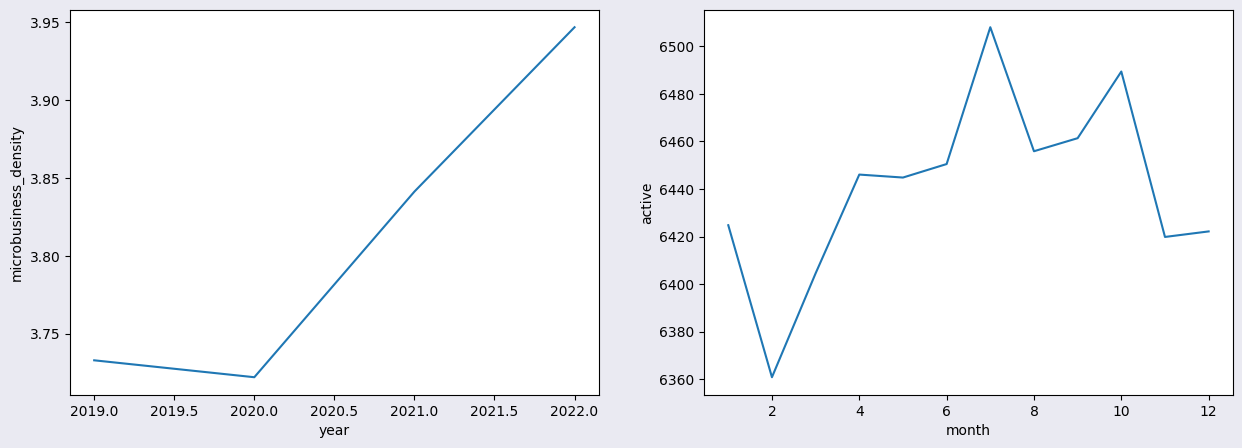

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), facecolor='#EAEAF2')
sns.lineplot(data=train_df.groupby('year').mean(),x='year',y='microbusiness_density',ax=axes[0])
sns.lineplot(data=train_df.groupby('month').mean(),x='month',y='active',ax=axes[1])
plt.show()

## Data pipeline and interactive context

In [96]:
# Location of the pipeline metadata store
PIPELINE_DIR = '../pipeline'

# Declare the InteractiveContext and use a local sqlite file as the metadata store.
context = InteractiveContext(pipeline_root=PIPELINE_DIR)

## ExampleGen


In [97]:
# Instantiate ExampleGen with the input CSV dataset
example_gen = tfx.components.CsvExampleGen(input_base=TRAINING_DIR)

# Run the component using the InteractiveContext instance
context.run(example_gen)

ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 14
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=CsvExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}))

## Compute Statistics

In [98]:
# Instantiate StatisticsGen with the ExampleGen ingested dataset
statistics_gen = tfx.components.StatisticsGen(example_gen.outputs['examples'])
    

# Run the component
context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 15
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}))

In [99]:
# Display the results
context.show(statistics_gen.outputs['statistics'])

## Inferring the Schema

In [100]:
# Instantiate SchemaGen with the output statistics from the StatisticsGen
schema_gen = tfx.components.SchemaGen(statistics_gen.outputs['statistics'])

# Run the component
context.run(schema_gen)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 16
    outputs:
        schema: OutputChannel(artifact_type=Schema, producer_component_id=SchemaGen, output_key=schema, additional_properties={}, additional_custom_properties={}))

In [101]:
# Visualize the output
context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'',INT,required,,-
'active',INT,required,,-
'cfips',INT,required,,-
'county',BYTES,required,,-
'median_hh_inc',FLOAT,required,,-
'microbusiness_density',FLOAT,required,,-
'month',INT,required,,-
'pct_bb',FLOAT,required,,-
'pct_college',FLOAT,required,,-


,Values
Domain,
'state',"'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'"
